
# ARSENL Backscatter Experiments

Grant Kirchhoff
06-23-2022
University of Colorado Boulder

Fit the photon arrival rate to exponentiated polynomial profiles from ARSENL INPHAMIS lidar. 

IMPORTANT: Set data path settings in
'load_ARSENL_data.py' first.

In [6]:
import numpy as np
import pandas as pd
import time
import pickle
import matplotlib.pyplot as plt
import torch
from scipy import stats
import os
import xarray as xr

In [31]:
### CONSTANTS ####
c = 299792458                      # [m/s] Speed of light
tstamp_int = 25                    # Timestamp interval (e.g., timestamp recorded in intervals of 25)
max_rollover = 2**25 * tstamp_int  # [ps] the maximum timestamp before instrument timer rolls over

### PARAMETERS ###
exclude_bnd = [25000, 35000]           # Set boundaries for binning to exclude outliers
exclude = True                     # Set TRUE to exclude data to work with smaller dataset
excl_val = 100000                  # Include up to certain value

cwd = os.getcwd()
data_dir = cwd + r'/../Data/Deadtime_Experiments_HiFi'
fname = r'/Dev_0_-_2022-04-15_10.49.58.ARSENL.OD00.ARSENL.nc'

In [32]:
ds = xr.open_dataset(data_dir+fname)                                   # xarray Dataset

flight_time = ds.time_tag * tstamp_int
distance = flight_time / 1e12 * c / 2

flight_time = flight_time[np.where((flight_time >= exclude_bnd[0]) \
                                   & (flight_time < exclude_bnd[1]))]  # Exclude specified t.o.f. bins

cnt_phot_fit = len(ds.sync_index)

if exclude:
    flight_time = flight_time[:excl_val]
    cnt_phot_fit = ds.sync_index[ds.time_tag_sync_index[excl_val].item()].item()

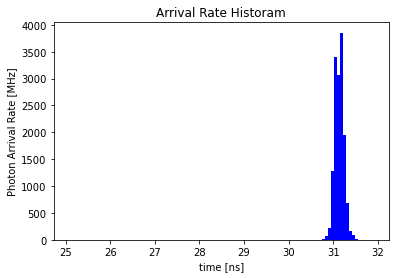

In [33]:
# Scaled time-of-flight histogram
fig = plt.figure()
ax = fig.add_subplot(111)
n, bins = np.histogram(flight_time/1000, bins=100)
binwidth = np.diff(bins)[0]
N = n / binwidth / 1e-9 / cnt_phot_fit  # [Hz] Scale counts to arrival rate
center = 0.5 * (bins[:-1] + bins[1:])
ax.bar(center, N/1e6, align='center', width=binwidth, color='b')
# ax.set_xlim([30,35])
ax.set_title('Arrival Rate Historam')
ax.set_xlabel('time [ns]')
ax.set_ylabel('Photon Arrival Rate [MHz]')
plt.show()

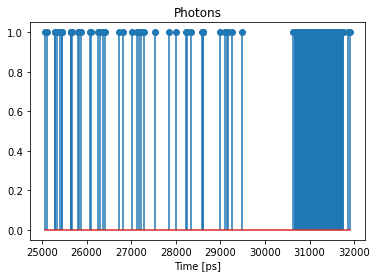

In [34]:
plt.figure()
plt.stem(flight_time, np.ones(flight_time.size))
plt.title('Photons')
plt.xlabel('Time [ps]')
plt.show()

### Now applying the curve_fit routine to my data. Code pulled from Matt Hayman's "Fit_TimeTag_Gaussian.ipynb" and adapted to fit to arbitrary exponentiated polynomials.

In [35]:
# Chebyshev polynomial matrix generator
def cheby_poly(x, M):
    """
    Parameters:
    x (array-like): Values to be evaluated on in chebyshev polynomial      \\ [Nx1]
    M (int)        : *Highest* order term of polynomial (e.g., x^2 --> M = 2) \\ []
    Returns:
    chebyshev polynomial matrix (array-like): Evaluated polynomial \\ [NxM]
    """
    
    def cheby(x, m):
        """
        Helper to calculate value of specific chebyshev order
        """
        T0 = x**0
        T1 = x**1
        if m == 0:   return T0
        elif m == 1: return T1
        else:        return 2*x*cheby(x, m-1) - cheby(x, m-2)
    
    N = len(x)
    model_out = np.zeros((N, M+1))
    for i in range(M+1):
        model_out[:, i] = cheby(x, i)
    
    return torch.tensor(model_out)

In [114]:
# build the fit model as a NN module
class Fit_Pulse(torch.nn.Module):
    def __init__(self, t_max):
        """
        Instantiate and initialize the fit parameters.
        """
        super().__init__()
   
        self.C10 = torch.nn.Parameter(-10*torch.ones(()))
        self.C9 = torch.nn.Parameter(10*torch.ones(()))
        self.C8 = torch.nn.Parameter(-10*torch.ones(()))
        self.C7 = torch.nn.Parameter(10*torch.ones(()))
        self.C6 = torch.nn.Parameter(-10*torch.ones(()))
        self.C5 = torch.nn.Parameter(10*torch.ones(()))
        self.C4 = torch.nn.Parameter(-10*torch.ones(()))
        self.C3 = torch.nn.Parameter(10*torch.ones(()))
        self.C2 = torch.nn.Parameter(-10*torch.ones(()))    # Quadratic term amplitude
        self.C1 = torch.nn.Parameter(10*torch.ones(()))    # Linear term amplitude
        self.C0 = torch.nn.Parameter(-11*torch.ones(()))    # DC term      
        self.A  = torch.nn.Parameter(300*torch.ones(()))  # Amplitude
        self.t_max = t_max                                    # Time elapsed per shot
        
        self.sqrt_2pi = torch.sqrt(torch.tensor(2*np.pi))
        self.sqrt_2  = torch.sqrt(torch.tensor(2.0))
        
    # Helper for numerical integration (trapezoidal method)
    @staticmethod
    def trapezoid(vals, dx):
        trap_intgrl = 0
        for i in range(len(vals)-1):
            trap_intgrl += vals[i] + vals[i+1]
        trap_intgrl *= dx/2
        return trap_intgrl

    def forward(self, t, intgrl_N):
        """
        Forward model the profile for input time t of polynomial order M (e.g., x^2 --> M=2).
        Also return the integral.
        t (array-like): time stamps (unnormalized)               \\ [Nx1]
        intgrl_N (int): number of steps in numerical integration \\ []
        """
        C10 = self.C10
        C9 = self.C9
        C8 = self.C8
        C7 = self.C7
        C6 = self.C6
        C5 = self.C5
        C4 = self.C4
        C3 = self.C3
        C2 = self.C2
        C1 = self.C1
        C0 = self.C0
        A  = self.A
        
        # orthonormalize by leveraging chebyshev polynomials, then calculate forward model
        t_norm = t / self.t_max       # Normalize timestamps 
        C = torch.ones(11, 1, dtype=float)
        C[0], C[1], C[2], C[3], C[4], C[5], C[6], C[7], C[8], C[9], C[10] = C0, C1, C2, C3, C4, C5, C6, C7, C8, C9, C10
        M = len(C) - 1
        t_poly_cheb = cheby_poly(t_norm, M)           # Generate chebyshev timestamp basis
        poly = t_poly_cheb @ C
        model_out = A*torch.exp(poly)             # Forward model
        
        # calculate the integral
        t_pts, dx = np.linspace(0, 1, intgrl_N, retstep=True)  # Normalized time vector
        t_poly_cheb = cheby_poly(t_pts, M)                        # Generate chebyshev time basis
        poly = t_poly_cheb @ C
        eval_model = A*torch.exp(poly)
        integral_out = self.trapezoid(eval_model, dx)            # Numerically integrate (trapezoidal)
            
        return model_out, integral_out

In [115]:
def pois_loss(prof,integral):
    """
    Poisson point process loss function
    prof: estimated photon arrival rate evaluated at
        each time tag
    integral: integral of prof at t_max
    """
    print(integral)
    print(torch.sum(torch.log(prof)))
    return integral-torch.sum(torch.log(prof))

In [116]:
# optimization parameters

rel_step_lim = 1e-10  # termination criteria based on step size
max_epochs = 500     # maximum number of iterations/epochs
learning_rate = 1e-1  # ADAM learning rate
term_persist = 20     # relative step size averaging interval in iterations

In data set, the frequency of the sync pulses is ~14.2kHz. Therefore, t_max ~= 70.2043 usec. Might need to look into having this dynamically adjusted.

In [117]:
# # I define the maximum time as a fixed value. This is the mode of the recorded elapsed time between shots.
# # Time vector per shot (sync event)
# t_min = 0
# avg_sync_diff = ds.sync_delta.mean() * tstamp_int / 1e12  # [s]
# t_max = avg_sync_diff.item()
# dt = tstamp_int * 1e-12                                    # [s]
# t_fine = np.arange(t_min, t_max, dt)

In [118]:
# I define the maximum time as a fixed value. This is the mode of the recorded elapsed time between shots.
# Time vector per shot (sync event)
t_min = exclude_bnd[0] * 1e-12
t_max = exclude_bnd[1] * 1e-12
dt = tstamp_int * 1e-12                                    # [s]
t_fine = np.arange(t_min, t_max, dt)

In [119]:
# initialize for fit loop
fit_model = Fit_Pulse(t_max)
optimizer = torch.optim.Adam(fit_model.parameters(), lr=learning_rate)
epoch = 0
rel_step = 1e3*rel_step_lim
train_loss_lst = []
rel_step_lst = []

init_C0 = fit_model.C0.item()
init_C1 = fit_model.C1.item()
init_C2 = fit_model.C2.item()
init_C3 = fit_model.C3.item()
init_C4 = fit_model.C4.item()
init_C5 = fit_model.C5.item()
init_C6 = fit_model.C6.item()
init_C7 = fit_model.C7.item()
init_C8 = fit_model.C8.item()
init_C9 = fit_model.C9.item()
init_C10 = fit_model.C10.item()
init_A  = fit_model.A.item()

In [120]:
# set the loss function to use a 
# Poisson point process likelihood function
loss_fn = pois_loss

In [121]:
intgrl_N = 1000                   # Set number of steps in numerical integration
t_phot_fit = flight_time * 1e-12  # [s] convert to seconds
t_phot_fit_tnsr = torch.tensor(t_phot_fit.to_numpy())

In [122]:
# perform fit
while rel_step > rel_step_lim and epoch < max_epochs:
    fit_model.train()
    pred, integral = fit_model(t_phot_fit_tnsr, intgrl_N)
    loss = loss_fn(pred, integral*cnt_phot_fit)  # add regularization here
    train_loss_lst += [loss.item()]

    # calculate relative step as an average over the last
    # term_persist iterations
    if epoch == 0:
        rel_step_lst+=[1e3*rel_step_lim]
        rel_step = 1e3*rel_step_lim
    else:
        rel_step_lst+=[(train_loss_lst[-2]-train_loss_lst[-1])/np.abs(train_loss_lst[-2])]
        rel_step = np.abs(np.array(rel_step_lst)[-term_persist:].mean())

    # update estimated parameters
    loss.backward()
    optimizer.step()
    
    # zero out the gradient for the next step
    optimizer.zero_grad()
    
    epoch+=1
    

tensor([8022022.7402], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(-166838.7789, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([4720346.0144], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(-174956.0261, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([3063049.6794], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(-181493.6079, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([2151035.8918], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(-185867.5927, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([1592724.4058], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(-188493.6361, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([1222423.5192], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(-189969.6020, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([963949.3331], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(-190730.9272, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([777543.8409], dtype=torch.float64, grad_fn=<MulBackward

tensor([102070.8904], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(-30256.0642, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([102570.0067], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(-25793.7185, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([103054.4408], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(-21366.4008, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([103521.3126], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(-16976.9358, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([103968.1940], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(-12627.5530, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([104393.0957], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(-8320.1972, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([104794.4514], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(-4056.5029, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([105171.0522], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(162.

tensor([116665.1793], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(176686.4389, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([116993.1747], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(178738.1236, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([117317.4268], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(180738.8255, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([117637.2319], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(182688.2833, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([117951.9802], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(184586.3825, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([118261.2422], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(186433.2482, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([118564.5520], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(188229.0619, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([118861.2487], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(18

tensor([121622.4491], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(232864.8260, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([121513.9412], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(233139.1584, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([121404.8060], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(233408.8241, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([121295.3107], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(233674.2155, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([121185.5255], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(233935.4647, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([121075.5214], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(234192.7245, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([120965.4235], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(234446.1984, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([120855.3022], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(23

tensor([115785.0444], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(245463.4147, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([115716.9069], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(245620.1446, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([115649.4534], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(245776.0205, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([115582.6662], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(245931.0518, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([115516.4475], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(246085.1649, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([115450.7873], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(246238.3568, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([115385.5760], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(246390.5360, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([115321.0888], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(24

tensor([112417.7289], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(253875.8082, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([112375.8992], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(253989.9356, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([112334.5018], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(254103.7182, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([112293.3648], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(254217.0097, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([112252.5506], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(254329.8753, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([112211.9172], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(254442.1742, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([112171.4930], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(254553.9480, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([112131.4215], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(25

tensor([110255.0847], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(260284.5314, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([110227.2210], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(260375.5673, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([110199.3368], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(260466.1418, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([110171.6735], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(260556.4967, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([110144.0907], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(260646.4952, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([110116.7328], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(260736.2753, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([110089.4697], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(260825.7140, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([110062.4888], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(26

tensor([108762.4338], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(265528.5154, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([108742.5026], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(265604.8489, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([108722.7203], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(265681.0437, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([108703.0256], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(265757.0358, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([108683.4195], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(265832.8338, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([108663.9636], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(265908.5031, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([108644.5170], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(265983.9027, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([108625.1214], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(26

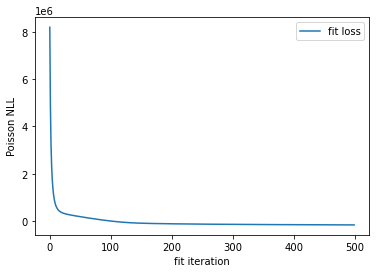

In [123]:
# plot the loss over iterations
plt.figure()
plt.plot(train_loss_lst,label='fit loss')
plt.xlabel('fit iteration')
plt.ylabel('Poisson NLL')
plt.legend()

In [124]:
t_tot_fine = np.arange(0, 60000*1e-12, dt)
pred_mod_full, integral_full = fit_model(torch.tensor(t_tot_fine), intgrl_N)

In [125]:
print('Initial C0: {}'.format(init_C0))
print('Initial C1: {}'.format(init_C1))
print('Initial C2: {}'.format(init_C2))
print('Initial C3: {}'.format(init_C3))
print('Initial C4: {}'.format(init_C4))
print('Initial C5: {}'.format(init_C5))
print('Initial C6: {}'.format(init_C6))
print('Initial C7: {}'.format(init_C7))
print('Initial C8: {}'.format(init_C8))
print('Initial C9: {}'.format(init_C9))
print('Initial C10: {}'.format(init_C10))
print('Initial A: {}'.format(init_A))

print('Final C0: {}'.format(fit_model.C0))
print('Final C1: {}'.format(fit_model.C1))
print('Final C2: {}'.format(fit_model.C2))
print('Final C3: {}'.format(fit_model.C3))
print('Final C4: {}'.format(fit_model.C4))
print('Final C5: {}'.format(fit_model.C5))
print('Final C6: {}'.format(fit_model.C6))
print('Final C7: {}'.format(fit_model.C7))
print('Final C8: {}'.format(fit_model.C8))
print('Final C9: {}'.format(fit_model.C9))
print('Final C10: {}'.format(fit_model.C10))
print('Final A: {}'.format(fit_model.A))

Initial C0: -11.0
Initial C1: 10.0
Initial C2: -10.0
Initial C3: 10.0
Initial C4: -10.0
Initial C5: 10.0
Initial C6: -10.0
Initial C7: 10.0
Initial C8: -10.0
Initial C9: 10.0
Initial C10: -10.0
Initial A: 300.0
Final C0: -13.376657485961914
Final C1: 5.837044715881348
Final C2: -9.14987564086914
Final C3: 10.80213737487793
Final C4: -12.104826927185059
Final C5: 5.475955963134766
Final C6: -10.539295196533203
Final C7: 6.298763751983643
Final C8: -12.091104507446289
Final C9: 10.039849281311035
Final C10: -6.321712970733643
Final A: 297.6167297363281


In [126]:
print("Sample average arrival time: {:.4f} ns".format(torch.mean(t_phot_fit_tnsr)*1e9))

Sample average arrival time: 31.1299 ns


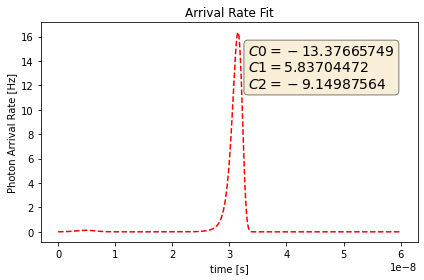

In [127]:
fig = plt.figure()
ax = fig.add_subplot(111)

# Arrival rate fit
fit_rate = pred_mod_full.detach().numpy()  # [Hz] Fitted arrival rate
ax.plot(t_tot_fine, fit_rate,'r--')
ax.set_title('Arrival Rate Fit')
ax.set_xlabel('time [s]')
ax.set_ylabel('Photon Arrival Rate [Hz]')
textstr = '\n'.join((
    r'$C0=%.8f$' % (fit_model.C0),
    r'$C1=%.8f$' % (fit_model.C1),
    r'$C2=%.8f$' % (fit_model.C2)))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.55, 0.90, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
plt.tight_layout()
plt.show()


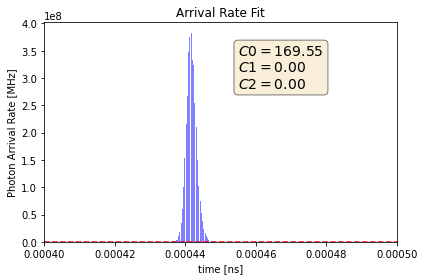

In [144]:
fig = plt.figure()
ax = fig.add_subplot(111)

# Scaled histogram
n, bins = np.histogram(flight_time/1000, bins=2000)
binwidth = np.diff(bins)[0]
N = n / binwidth / 1e-9 / cnt_phot_fit  # [Hz] Scaling counts to arrival rate
center = 0.5 * (bins[:-1] + bins[1:])
ax.bar(center, N/1e6, align='center', width=binwidth, color='b', alpha=0.5)

# Arrival rate fit
fit_rate = pred_mod_full.detach().numpy()  # [Hz] Fitted arrival rate
ax.plot(t_fine*1e9, fit_rate/1e6,'r--')
ax.set_xlim([26, 40])
ax.set_title('Arrival Rate Fit')
ax.set_xlabel('time [ns]')
ax.set_ylabel('Photon Arrival Rate [MHz]')
textstr = '\n'.join((
    r'$C0=%.2f$' % (torch.exp(fit_model.C0)),
    r'$C1=%.2f$' % (torch.exp(fit_model.C1)),
    r'$C2=%.2f$' % (torch.exp(fit_model.C2))))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.55, 0.90, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
plt.tight_layout()
plt.show()



### Graveyard ###

In [93]:
class NumericalIntegrator:
    def riemann(f, eval_pts, dx):
        integral = 0
        for i in range(len(eval_pts)):
            integral += f(eval_pts[i])
        integral *= dx
        return integral

    def trapezoidal(f, eval_pts, dx):
        integral = 0
        for i in range(len(eval_pts)-1):
            integral += f(eval_pts[i]) + f(eval_pts[i+1])
        integral *= dx / 2
        return integral

    def simpsons(f, eval_pts, dx):
        integral = 0
        for i in range(len(eval_pts)-2):
            integral += f(eval_pts[i]) + 4*f(eval_pts[i+1]) + f(eval_pts[i+2])
        integral *= dx / 2 / 3
        return integral
